In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-dataset/Creditcard_data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('/kaggle/input/credit-card-dataset/Creditcard_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    772 non-null    int64  
 1   V1      772 non-null    float64
 2   V2      772 non-null    float64
 3   V3      772 non-null    float64
 4   V4      772 non-null    float64
 5   V5      772 non-null    float64
 6   V6      772 non-null    float64
 7   V7      772 non-null    float64
 8   V8      772 non-null    float64
 9   V9      772 non-null    float64
 10  V10     772 non-null    float64
 11  V11     772 non-null    float64
 12  V12     772 non-null    float64
 13  V13     772 non-null    float64
 14  V14     772 non-null    float64
 15  V15     772 non-null    float64
 16  V16     772 non-null    float64
 17  V17     772 non-null    float64
 18  V18     772 non-null    float64
 19  V19     772 non-null    float64
 20  V20     772 non-null    float64
 21  V21     772 non-null    float64
 22  V2

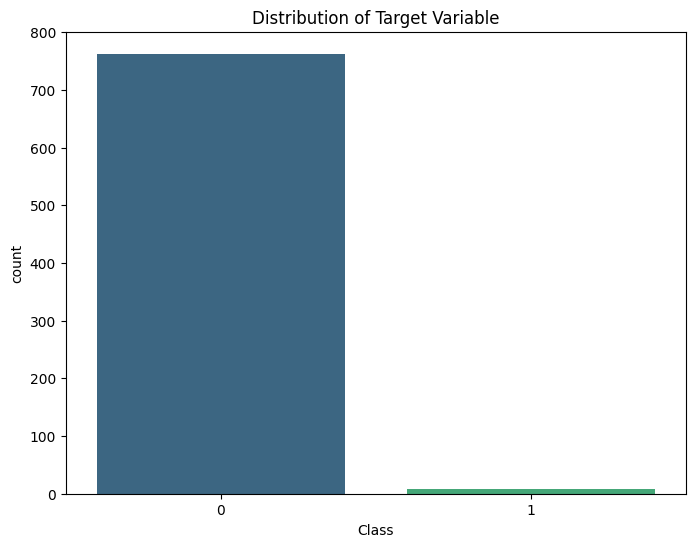

In [5]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Distribution of Target Variable')
plt.show()

In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]


**BALANCING IMBALANCED DATA****

In [7]:
# Apply oversampling to the minority class
oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversampler.fit_resample(X, y)

# Apply undersampling to the majority class
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)


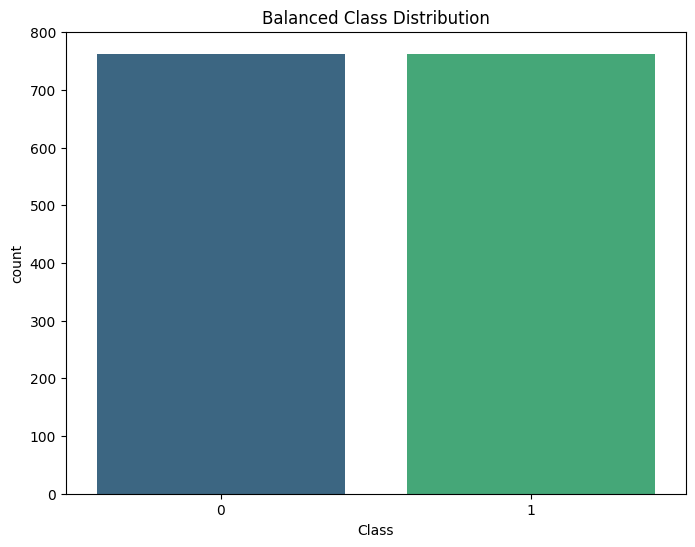

In [8]:
# Combine features and target into a new DataFrame
balanced_df = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name="Class")], axis=1)

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="Class", data=balanced_df, palette='viridis')
plt.title("Balanced Class Distribution")
plt.show()

In [9]:

# Defining desired confidence level, margin of error, and estimated proportion
confidence_level = 0.95 
margin_of_error = 0.05  
estimated_proportion = 0.5  # assuming equal probability for binary classification

# Calculate the Z-score based on the confidence level
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

# Calculate the required sample size
req_sample_size = int(np.ceil((z_score**2 * estimated_proportion * (1 - estimated_proportion)) / margin_of_error**2))

print(f"Required sample size: {int(np.ceil(req_sample_size))}")

Required sample size: 385


In [10]:
# Create five samples with corresponding y values
samples = [(X_balanced.sample(n=req_sample_size, random_state=i), 
            y_balanced.sample(n=req_sample_size, random_state=i)) for i in range(5)]


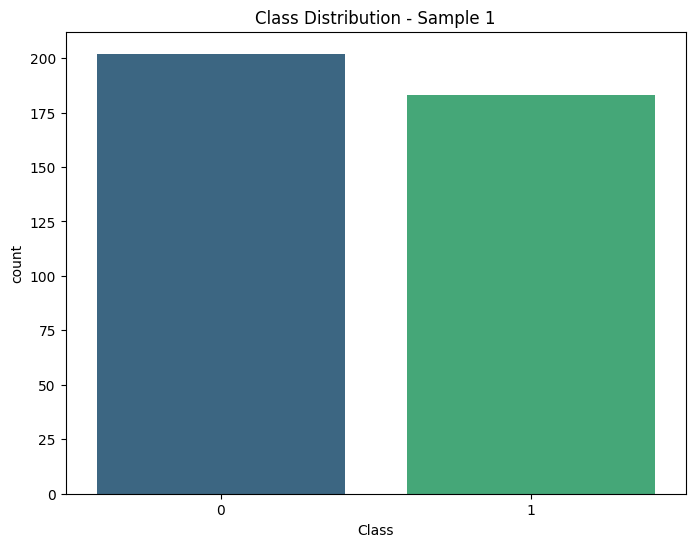

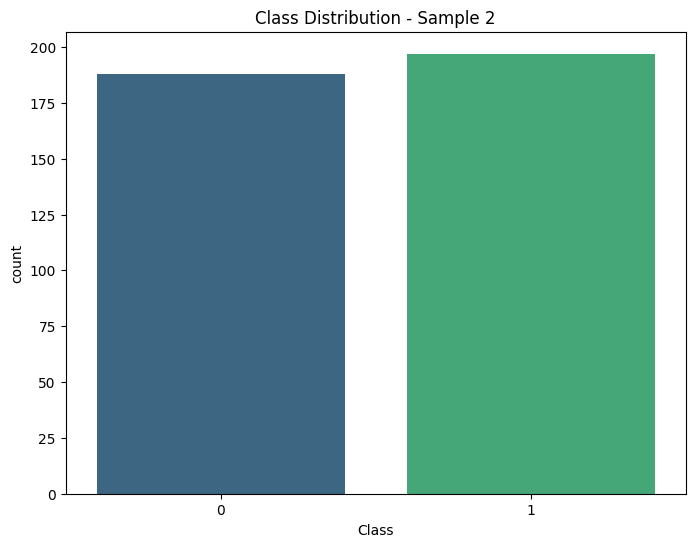

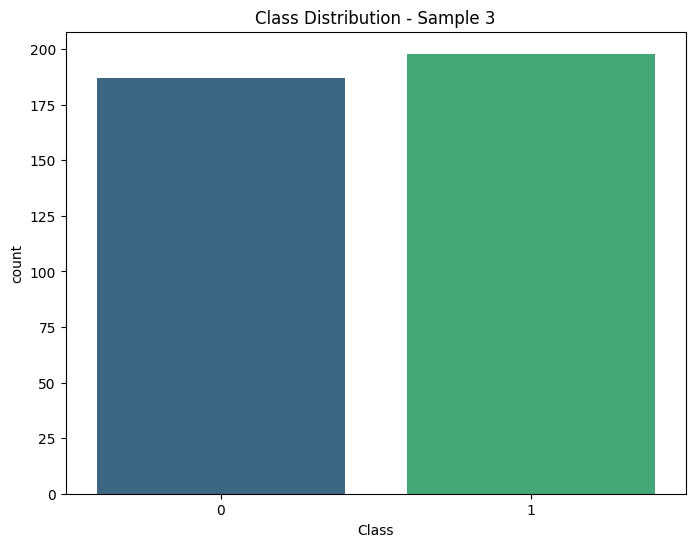

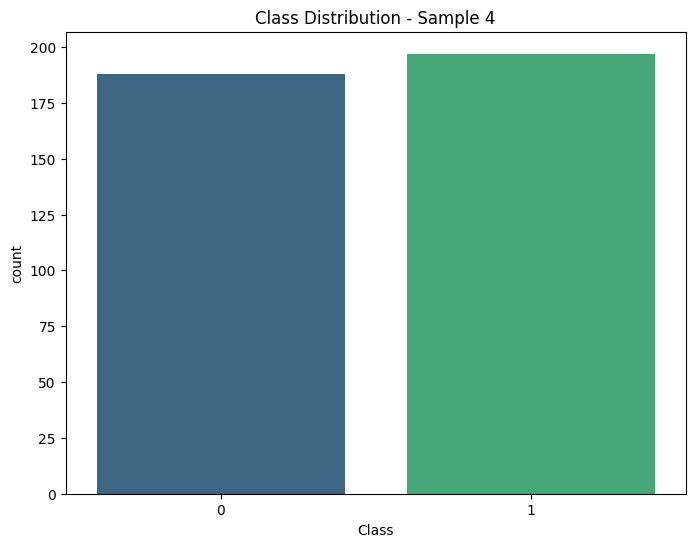

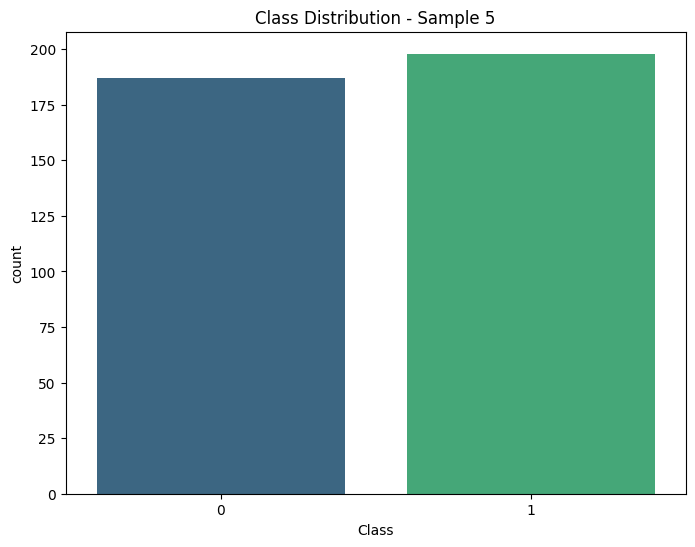

In [11]:

# Assuming 'samples' is the list of tuples containing (X_sample, y_sample)

for i, (X_sample, y_sample) in enumerate(samples):
    # Combine features and target into a new DataFrame
    sample_df = pd.concat([X_sample, pd.Series(y_sample, name="Class")], axis=1)
    
    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x="Class", data=sample_df, palette='viridis')
    plt.title(f"Class Distribution - Sample {i + 1}")
    plt.show()

**DIFFERENT SAMPLING TECHNIQUES OVER DIFFERENT ML MODELS**

In [12]:

# Define models
models = [RandomForestClassifier(random_state=42),
          LogisticRegression(random_state=42, max_iter=1000),
          SVC(random_state=42),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=42)]
        
# Define sampling techniques
sampling_techniques = [RandomOverSampler(),
                       SMOTE(),
                       ADASYN(),
                       RandomUnderSampler(),
                       NearMiss()]


In [13]:
# Initialize a dictionary to store the results
results = {}


In [14]:
from sklearn.preprocessing import StandardScaler
# Loop over models and sampling techniques
for model in models:
    model_name = model.__class__.__name__
    results[model_name] = {}

    for technique in sampling_techniques:
        technique_name = technique.__class__.__name__

        # Apply sampling technique
        X_resampled, y_resampled = technique.fit_resample(X_balanced, y_balanced)

        # Scale the data
        scaler = StandardScaler()
        X_resampled_scaled = scaler.fit_transform(X_resampled)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled_scaled, y_resampled, test_size=0.2, random_state=42
        )

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store the result
        results[model_name, technique_name] = accuracy

In [15]:
# Display the results
for key, value in results.items():
    if isinstance(value, dict):
        # For models without sampling techniques
        model_name = key
        print(f"Model: {model_name}, No Sampling Technique, Accuracy: No result")
    else:
        # For models with sampling techniques
        (model_name, technique_name) = key
        accuracy = value
        print(f"Model: {model_name}, Sampling Technique: {technique_name}, Accuracy: {accuracy:.2%}")


Model: RandomForestClassifier, No Sampling Technique, Accuracy: No result
Model: RandomForestClassifier, Sampling Technique: RandomOverSampler, Accuracy: 100.00%
Model: RandomForestClassifier, Sampling Technique: SMOTE, Accuracy: 100.00%
Model: RandomForestClassifier, Sampling Technique: ADASYN, Accuracy: 100.00%
Model: RandomForestClassifier, Sampling Technique: RandomUnderSampler, Accuracy: 100.00%
Model: RandomForestClassifier, Sampling Technique: NearMiss, Accuracy: 100.00%
Model: LogisticRegression, No Sampling Technique, Accuracy: No result
Model: LogisticRegression, Sampling Technique: RandomOverSampler, Accuracy: 94.12%
Model: LogisticRegression, Sampling Technique: SMOTE, Accuracy: 94.12%
Model: LogisticRegression, Sampling Technique: ADASYN, Accuracy: 94.12%
Model: LogisticRegression, Sampling Technique: RandomUnderSampler, Accuracy: 93.79%
Model: LogisticRegression, Sampling Technique: NearMiss, Accuracy: 94.12%
Model: SVC, No Sampling Technique, Accuracy: No result
Model: S

In [16]:
best_model = None
best_technique = None
best_accuracy = float('-inf')

# Iterate over results to find the best model and sampling technique
for key, value in results.items():
    if not isinstance(value, dict) and value > best_accuracy:
        best_model, best_technique = key
        best_accuracy = value

# Display the result
if best_model is None:
    print("No results found.")
elif isinstance(best_technique, dict):
    print(f"No Sampling Technique found with highest accuracy for Model: {best_model}, Accuracy: No result")
else:
    print(f"Model with highest accuracy: {best_model}, Sampling Technique: {best_technique}, Accuracy: {best_accuracy:.2%}")


Model with highest accuracy: RandomForestClassifier, Sampling Technique: RandomOverSampler, Accuracy: 100.00%
